# Real Time Power Prices

> Historical Real Time NZ Power Pricing Data

In [1]:
#| default_exp power

In [2]:
#| hide
from nbdev.showdoc import *

In [10]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from datetime import datetime, timedelta
from scipy.stats import skew, skewnorm
import random

The data is sourced from the [Electricity Authority](https://www.emi.ea.govt.nz/Wholesale/Datasets/FinalPricing).

The data aims to provide a real signal that can be used to interact with the hot water model simulation. In some cases this data is used as a proxy for the carbon content of the generated electricity. This is not a perfect proxy, but it is a reasonable one.


In [11]:
#| export
def get_season(date):
  month = date.month
  if month  >= 3 and month <= 5:
    return "Autumn"
  elif month >= 6 and month <= 8:
    return "Winter"
  elif month >= 9 and month <= 11:
    return "Spring"
  else:
    return "Summer"

In [51]:
#| export
def load_power(path = None, ripple_control = False):
    "Return power price"
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']

    season_skew = [1.7, 1.9, 1.2, 1.8]
    season_freq = [0.1, 0.3, 0.6, 0.2]
    season_mean = [52, 45, 70, 50]
    season_std = [80, 52, 61, 60]
    df = (pd.read_csv(path/'powerprices.csv')
            .assign(timestamp = lambda df_: pd.to_datetime(df_.dt))
            .set_index('timestamp')
            .drop(columns = ['dt', 'poc', 'date', 'time', 'island','del', 'del2', 'del3'])
            .sort_index()
            .resample('60S')
            .mean()
            .interpolate()
            .assign(price = lambda df_: df_.price.interpolate(method='linear'),
                ripple_control = False,
                price_kw = lambda df_: df_.price/1000,
                date = lambda df_: df_.index.date,
                week = lambda df_: df_.index.isocalendar().week,
                season = lambda df_: df_.index.map(get_season),
                hour = lambda df_: df_.index.hour,
                day = lambda df_: df_.index.dayofweek,
                peak = lambda df_: np.where((df_.hour.isin([7,8,9,10,17,18,19,20])& (~df_.day <5)), 1, 0), # 1 if peak hour, 0 otherwise
                tou = lambda df_: np.where((df_.hour.isin([7,8,9,10,17,18,19,20])& (~df_.day <5)), .12, .02), # add tou price
                cost = lambda df_: df_.price_kw+df_.tou, # add tou price
                n_cost = lambda df_ :-0.5+ (df_.cost - 0) / (.1 - 0), # normalize cost - bit hacky
                sr_cost = lambda df_ :df_.cost.rolling(60).mean().shift(-60)/df_.cost/6, # provide a 1 hour (short run) rolling average of cost
                lr_cost = lambda df_ :df_.cost.rolling(120).mean().shift(-120)/df_.cost/6, # provide a 2 hour (longer run) rolling average of cost
            )
            .dropna()
            .drop(columns=['trade'])
            )

    i=0
    if ripple_control:
        for season, freq in zip(seasons, season_freq):
            ripple_dates = df[(df.season == season)&(df.day < 5)&(df.cost >.4)].drop_duplicates('date').sample(frac=freq).index
            for date in ripple_dates:
                    start_hour = random.choice([6,7,8,9,10,17,18,19,20])
                    start_minute = random.randint(0,59)
                    start_time = date + timedelta(hours=start_hour, minutes=start_minute)
                    end_time = start_time + timedelta(minutes=max(15, skewnorm.rvs(2, loc=season_mean[i], scale=season_std[i], size=1)[0]))
                    df['ripple_control'] = np.where((df.index >= start_time) & (df.index <= end_time), True, df['ripple_control'])    
            i+=1
    return df

In [52]:
skewnorm.rvs(2, loc=60, scale=120, size=1)[0]

191.70848257113386

In [53]:
df = load_power(path = Path('../data'), ripple_control = True)
df.loc['2020-01']

,price,ripple_control,price_kw,date,week,season,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,,
2020-01-01 00:00:00,7.920,False,0.007920,2020-01-01,1,Summer,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,8.526,False,0.008526,2020-01-01,1,Summer,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,9.132,False,0.009132,2020-01-01,1,Summer,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,9.738,False,0.009738,2020-01-01,1,Summer,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,10.344,False,0.010344,2020-01-01,1,Summer,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:55:00,37.480,False,0.037480,2020-01-31,5,Summer,23,4,0,0.02,0.057480,0.07480,0.061746,0.059896
2020-01-31 23:56:00,30.010,False,0.030010,2020-01-31,5,Summer,23,4,0,0.02,0.050010,0.00010,0.069304,0.068010
2020-01-31 23:57:00,22.540,False,0.022540,2020-01-31,5,Summer,23,4,0,0.02,0.042540,-0.07460,0.080004,0.079217


In [54]:
df.cost.rolling(window=240).apply(lambda x: x.rank())

TypeError: cannot convert the series to <class 'float'>

In [ ]:
# add a column for rank of price compared to the next 4 hours
df.cost.rolling(window=4*60).rank(pct=True).shift(-4*60)


timestamp
2020-01-01 00:00:00    0.222917
2020-01-01 00:01:00    0.225000
2020-01-01 00:02:00    0.227083
2020-01-01 00:03:00    0.229167
2020-01-01 00:04:00    0.231250
                         ...   
2020-12-31 21:51:00         NaN
2020-12-31 21:52:00         NaN
2020-12-31 21:53:00         NaN
2020-12-31 21:54:00         NaN
2020-12-31 21:55:00         NaN
Freq: 60S, Name: cost, Length: 526916, dtype: float64

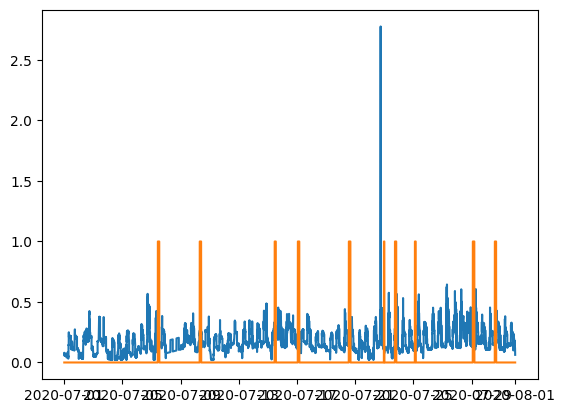

In [55]:
plt.plot(df.loc['2020-07'].cost)
plt.plot(df.loc['2020-07'].ripple_control)

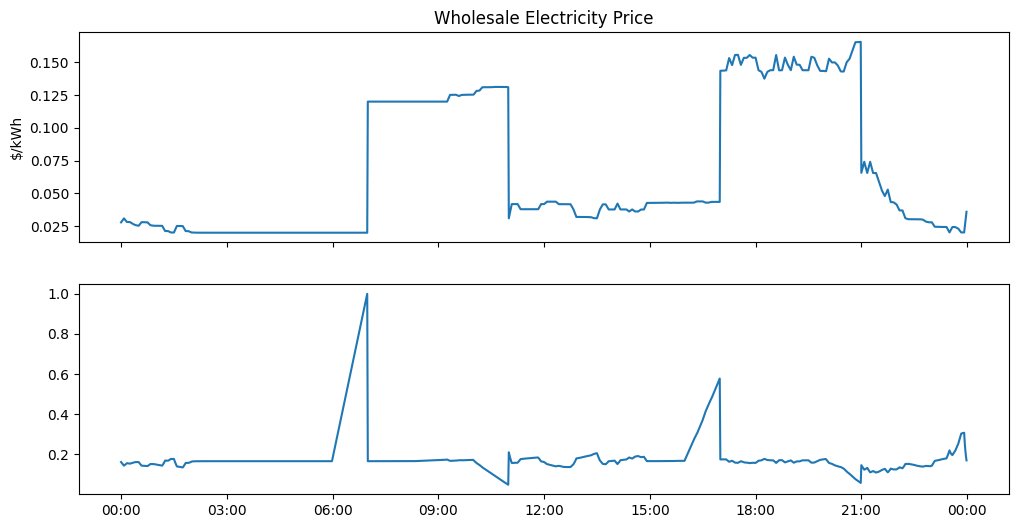

In [34]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6), sharex=True)
ax[0].plot(df.loc['2020-01-01'].cost)
ax[0].set_ylabel('$/kWh')
ax[0].set_title('Wholesale Electricity Price')
ax[1].plot(df.loc['2020-01-01'].sr_cost)
# set ax[1] x axis labels to HH:MM
# set this formatter to the axis
# ax[1].xaxis.set_major_formatter(fmtr)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))


In [9]:
#| hide
import nbdev; nbdev.nbdev_export()